In [1]:
import sys
sys.path.append('C:/Users/asus/text2face/FGTD/scripts')

# Import dependencies

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.optimizer import Optimizer, required

from dataclasses import dataclass, asdict
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

In [3]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

## Initializing helper functions

In [4]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Initializing constants

In [5]:
@dataclass
class Config:
    epochs: int = 101
    batch_size: int = 16
    subset_size: int = 30_000

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    num_channels: int = 3
    attention: bool = True
    
    embedding_dim: int = 768
    reduced_embedding_dim: int = 768

    g_lr: float = 0.0001
    d_lr: float = 0.0004

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
cfg = Config()
cfg_dict = asdict(cfg)

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [7]:
# File Constants
ZIP_PATH = "."
OUTPUT_DIR = "C:/Users/asus/text2face/FGTD/dataset/img_align_celeba/"

In [8]:
# extract_zip(ZIP_PATH, OUTPUT_DIR)

# Create Sentence Encoder

In [9]:
sentence_encoder = SentenceEncoder(cfg.device)

# Create DataLoader

In [10]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'C:/Users/asus/text2face/FGTD/dataset/celebA_bangla.csv',  
    image_location=OUTPUT_DIR,
    text_desc_location='C:/Users/asus/text2face/FGTD/dataset/text_1_bn_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 30000
Classes present:  {'আকর্ষণীয়', 'ঘন_ভ্রু', 'গোলাপী_গাল', 'অল্পবয়স্ক', 'নেকলেস_পরা', 'ভারী_মেকাপ', 'বড়_নাক', 'চশমা', 'উঁচু_গালের_হাড়', 'হালকা_দাড়ি', 'মোছ', 'সোজা_চুল', 'কানের_দুল_পরা', 'কালো_চুল', 'মুখ_কিছুটা_খোলা', 'লিপস্টিক_পরা', 'সামনের চুল কম', 'টুপি_পরা', 'টাই_পরা', 'চোখা_নাক', 'ফ্যাকাশে', 'বাদামী_চুল', 'Unnamed: 0', 'টাক', 'সরু_চোখ', 'কপালে_ছড়ানো_চুল', 'বড়_ঠোঁট', 'গোটি', 'জুলফি', 'ধূসর_চুল', 'দাড়ি_নেই', 'সোনালী_চুল', 'ঢেউ_খেলানো_চুল', 'চোখের_নিচে_কালি', 'হাসি', 'পুরুষ', 'দ্বীত্ব_থুতনি', 'কুচকানো_ভুরু', 'মোটা', 'ডিম্বাকৃতির_চেহারা'}
Number of classes:  40
Length of subset dataset: 30000


  0%|          | 0/30000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


## Testing DataLoader output

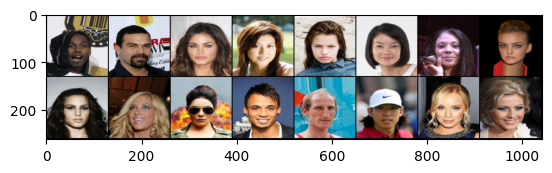

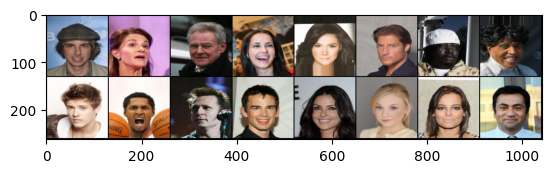

['ছেলেটির ভ্রু কুচকানো ছিল। ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির বড় ঠোঁট ছিল। ছেলেটির বড় নাক ছিল। ছেলেটির কালো চুল ছিল। ছেলেটির উঁচু গালের হাড় ছিল। ছেলেটির মুখ কিছুটা খোলা ছিল। ছেলেটির সামনের চুল কম ছিল। ছেলেটির মুখে ছিল হাসি। ', 'ভদ্রলোকটির চোখের নিচে কালি ছিল। ভদ্রলোকটির বড় নাক ছিল। ভদ্রলোকের কালো চুল ছিল। ভদ্রলোকের সোনালী চুল ছিল। ভদ্রলোকেটি দেখতে মোটা ছিল। ভদ্রলোকের মুখে গোটি দাঁড়ি ছিল। ভদ্রলোকের মুখে মোছ ছিল। ভদ্রলোকটির জুলফি ছিল। ', 'মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির বড় ঠোঁট ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির চোখা নাক ছিল। মেয়েটির গোলাপী গাল ছিল। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। মেয়েটির নেকলেস পরা ছিল। ', 'ছেলেটির মুখে ছিল হালকা দাড়ি। ছেলেটির দাড়ি নেই। ছেলেটির চেহারা ফ্যাকাশে। ', 'মেয়েটির কাল

In [11]:
images, labels, wrong_images = weighted_dataiter._next_data()
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

## Creating BERT sent embeddings

In [12]:
output = sentence_encoder.convert_text_to_embeddings(labels)
print(output)
print(output.shape)

tensor([[-0.2834,  0.3521, -0.2956,  ...,  0.8593,  0.6025, -0.0602],
        [ 0.1877,  0.3571, -0.5622,  ...,  0.1310,  0.1575, -0.2554],
        [ 0.1055,  0.2131, -0.5963,  ..., -0.1678,  0.0903,  0.0950],
        ...,
        [ 0.0267,  0.2916, -0.4132,  ...,  0.5598,  0.1797,  0.0702],
        [-0.0547,  0.2922, -0.4162,  ...,  0.0435,  0.2458,  0.0984],
        [ 0.0479,  0.1135, -0.5444,  ...,  0.1321,  0.0260,  0.0489]],
       device='cuda:0')
torch.Size([16, 768])


## Initialize weights

In [13]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Defining Attention Module

In [14]:
class Self_Attn(nn.Module):
  '''
  Self attention layer
  '''
  def __init__(self, in_dim):
    super().__init__()

    self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

    self.gamma = nn.Parameter(torch.zeros(1))
    self.softmax = nn.Softmax(dim = -1)


  def forward(self, x):
    batch_size, C, width, height = x.size()
    query = self.query_conv(x).view(batch_size, -1, width * height).permute(0,2, 1)
    key = self.key_conv(x).view(batch_size, -1, width * height)
    energy = torch.bmm(query, key)

    attn = self.softmax(energy)
    value = self.value_conv(x).view(batch_size, -1, width * height)
    out = torch.bmm(value, attn.permute(0, 2, 1))
    out = out.view(batch_size, C, width, height)

    out = self.gamma * out + x
    return out, attn

In [15]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

In [16]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [17]:
class Generator(nn.Module):
  '''
  Generator architecture
  '''
  def __init__(self, noise_size, embedding_size, reduced_dim_size, num_channels, image_size, attn = True, feature_size = 64):
    super(Generator, self).__init__()
    self.attn = attn
    self.noise_dim = noise_size
    
    assert image_size in [64, 128, 256], "Can only generate images for 64, 128 and 256 dimensions."
    self.image_size = image_size

    ########## Embedding Layer ##########
    self.encode_layer = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.BatchNorm1d(reduced_dim_size),
        nn.ReLU(),
        nn.Linear(reduced_dim_size, noise_size),
        nn.BatchNorm1d(noise_size),
        nn.ReLU(),
    )

    # Size 1 -> 4
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = noise_size, out_channels = feature_size*8, kernel_size = 4)),
        nn.BatchNorm2d(feature_size*8),
        nn.ReLU()
    )
    
    # Size 4 -> 8
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*8, out_channels = feature_size*4, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*4),
        nn.ReLU()
    )
    
    # Size 8 -> 16
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*4, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )

    # Attn1 layer turn 16 dims -> 16 dims
    self.attn1 = Self_Attn(feature_size*2)
    
    # Size 16 -> 32
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )
    
    # Attn2 layer turn 32 dims -> 32 dims
    self.attn2 = Self_Attn(feature_size*2)

    final_size = feature_size * 2
    
    if image_size >= 128:
        # Size 32 -> 64
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
            nn.BatchNorm2d(feature_size*2),
            nn.ReLU()
        )

        final_size = feature_size * 2

        # Attn3 layer turn 64 dims -> 64 dims
        self.attn3 = Self_Attn(feature_size*2)

        if image_size == 256:
            # Size 64 -> 128
            self.layer6 = nn.Sequential(
                SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size, kernel_size = 4, stride = 2, padding = 1)),
                nn.BatchNorm2d(feature_size),
                nn.ReLU()
            )

            final_size = feature_size

        

    # Output last_dim -> last_dim * 2
    self.output_layer = nn.Sequential(
        nn.ConvTranspose2d(final_size, 3, 4, 2, 1),
        nn.Tanh()
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.0, 0.9))

  def forward(self, noise, text_embeddings):
    encoded_text = self.encode_layer(text_embeddings)
    # Concatenating the noise and encoded text
    concat_input = torch.mul(noise, encoded_text).view(-1, self.noise_dim, 1, 1)
    
    x = self.layer1(concat_input)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)
        

    x = self.output_layer(x)
    return x


In [18]:
generator = Generator(cfg.noise_size, cfg.embedding_dim, cfg.reduced_embedding_dim, cfg.num_channels, cfg.image_size, attn=cfg.attention, feature_size=cfg.feature_size)
generator.cuda()

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=768, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [19]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()

## Calculation

In [20]:
from facenet_pytorch import MTCNN, InceptionResnetV1

In [21]:
def fsdcalc(real,fake):
        # If required, create a face detection pipeline using MTCNN:
    mtcnn = MTCNN(
        image_size=128, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=0
    )

    # Create an inception resnet (in eval mode):
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    
    real = real.to(device='cpu')
    fake = fake.to(device='cpu')
    
    img_embedding1 = resnet(real)
    img_embedding2 = resnet(fake)

    fsd = torch.sum(torch.abs((img_embedding1-img_embedding2)))/16

    return fsd

In [22]:
def fsscalc(real,fake):
        # If required, create a face detection pipeline using MTCNN:
    mtcnn = MTCNN(
        image_size=128, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=0
    )

    # Create an inception resnet (in eval mode):
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    
    real = real.to(device='cpu')
    fake = fake.to(device='cpu')
    
    img_embedding1 = resnet(real)
    img_embedding2 = resnet(fake)

    cos = torch.nn.CosineSimilarity(dim=1)

    fss = torch.sum(cos(img_embedding1,img_embedding2))/16

    return fss

In [23]:
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)
metric = InceptionScore()
metric.attach(default_evaluator, "is")

In [24]:
generator_path = 'C:/Users/asus/text2face/FGTD/Face-GANs/SAGAN/SAGAN_hd_generators/' # .pt files of generators at different epochs

In [25]:
from lpips_pytorch import lpips

# plotting LPIPS at each epoch

In [28]:
epoch_number = 0

for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    
    if(epoch_number>150):
        break

    # Current batch size
    current_batch_size = real_images.size()[0]

    # Convert to cuda
    real_images = real_images.cuda()
    wrong_images = wrong_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    
    current_path = generator_path + str(epoch_number) + '.pt'
    generator.load_state_dict(torch.load(current_path)['generator_state_dict'])

    generator.zero_grad()
    input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
    fake_images = generator(input_noise, text_embeddings)
    
    score = float(lpips(real_images,fake_images,net_type='alex', version='0.1')[0][0][0][0].detach().cpu())
    print(score)
    
    epoch_number += 5


C:\Users\asus\anaconda3\envs\fgbtd\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\asus\anaconda3\envs\fgbtd\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


9.993688583374023
7.426368713378906
7.11385440826416
7.8047404289245605
7.401918411254883
7.4428911209106445
7.604758262634277
7.414636611938477
7.501029968261719
7.21114444732666
8.000093460083008
8.742833137512207
7.404119968414307
7.570811748504639
7.784897804260254
7.500308990478516
7.997015476226807
7.451594352722168
7.771244049072266
7.900476455688477
7.886757850646973


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/asus/text2face/FGTD/Face-GANs/SAGAN/SAGAN_hd_generators/105.pt'